<a href="https://colab.research.google.com/github/PauloSouza-GV/Jupyter/blob/master/Classifica%C3%A7%C3%A3o_de_propostas_e_leitura_com_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://www.moradadapaz.com.br/app/themes/mobister/dist/images/logo-desk.png'>

# **Classificação e leitura automática de propostas**

**Introdução, objetivos e especificações**

É comum que empresas que realizem vendas, possuam sistemas próprios para cadastro e controle, muitas empresas também não possuem formulários inteligentes para os clientes, necessitando que seja feito o preenchimento de uma proposta fisica, que posteriormente será armazenada no sistema através da digitação de algum operador. 
<br>Este processo além de custoso, gera erros operacionais e muitas vezes é um processo demorado.

>**Objetivos**

Realizar a leitura da proposta fisica através de um OCR, criação de uma Bag of Words dessa leitura e fazer predições de montagem e entrega. Também serão feitas algumas medições para informar o perfil médio de pagamento da localidade.

>**Especificações técnicas**

Dataset: Para este projeto será utilizada uma database própria, extraída da empresa alvo.

Formato: A base de dados estará em formato CSV, com separador em ;(ponto e virgula) e estará dividida em certas colunas, são elas:

1.   **Estado:** Estado federativo do cliente
2.   **Cidade** Cidade do cliente
3.   **Bairro:** Bairro do cliente
4.   **Emissão:** Emissão da proposta
5.   **Entrega:** Entrega do objeto da proposta
5.   **Cliente(anonimizado):** Código de referencia para o cliente
6.   **Situação da mensalidade:** Situação financeiro do cliente na base

Metodos de pré-processamento:


*   Remoção de dados nulos
*   Retirada de espaços em branco desnecessários e caracteres especiais e acentuações
*   Remoção de dados duplicados
*   Será realiza a transformação dos campos de data e valores
*   Será feita a discretização no campo de situação da mensalidade


Algoritimos que seram utilizados na predição de montagem e medições:






# Leitura da proposta

In [1]:
#Primeiramente será iniciado a instalação do PyTesseract
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,798 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [2]:
#Será feito a importação das bibliotecas
import pytesseract
import shutil
import os
import random
try:
  from PIL import Image
except ImportError:
  import Image

In [3]:
# Chama o dialog para fazer o upload da imagem
from google.colab import files
uploaded = files.upload()
fileOCR=""

for fn in uploaded.keys():
  fileOCR=fn

Saving 0001.jpg to 0001.jpg


In [4]:
# Começa a extração das informações
ExtractedInformation=pytesseract.image_to_string(Image.open(fileOCR), lang='eng')

In [5]:
# Imprime o documento em formato texto
print( ExtractedInformation )

Proposta de venda

PROPOSTA DE VENDA N° 00253052

01. Plano
(| )Sempre
( X )Essencial

02. Sexo do cliente

( X ) Masculino

( ) Feminino

( ) Outros

03. Nome do Cliente

Paulo Henrique Liberato de Souza
04. CPF:

071.730.934-73

05. Endereco

 

Estado: RN

 

Municipio: Natal

 

Bairro: Centro

 

 

Endereg¢o: Rua Rolddo Augusto Botelho

 

 



In [6]:
# realizando algumas limpezas e padronizações
import re
ExtractedInformation = re.sub('[^A-Za-z]', ' ', ExtractedInformation)
ExtractedInformation = ExtractedInformation.lower()             

In [7]:
# criando e aplicando o vetorizador
from sklearn.feature_extraction.text import CountVectorizer
bag=ExtractedInformation
bag = bag.split('\n')
vectorizer = CountVectorizer()
vectorizer.fit(bag)

# Imprimindo o vocabulario
print(vectorizer.vocabulary_)

#transformando em vetor para futuramente ser utilizado para identificação da proposta especifica
matrix=vectorizer.transform(bag)

{'proposta': 22, 'de': 6, 'venda': 29, 'plano': 21, 'sempre': 26, 'essencial': 10, 'sexo': 27, 'do': 7, 'cliente': 4, 'masculino': 15, 'feminino': 12, 'outros': 19, 'nome': 18, 'paulo': 20, 'henrique': 13, 'liberato': 14, 'souza': 28, 'cpf': 5, 'endereco': 8, 'estado': 11, 'rn': 23, 'municipio': 16, 'natal': 17, 'bairro': 1, 'centro': 3, 'endereg': 9, 'rua': 25, 'rolddo': 24, 'augusto': 0, 'botelho': 2}


# Busca informações da base

In [90]:
#Realizando a declaração dos imports
%matplotlib inline 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os as system
import locale
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import svm 

In [91]:
#Configurações monetárias
locale.setlocale( locale.LC_MONETARY, 'en_US.utf8' )

'en_US.utf8'

In [92]:
#Informo qual o stylo que será plotado dos graficos
plt.style.use('grayscale')

In [100]:
#Em seguida irei realizar a leitura inicial do arquivo e armazenar em uma váriavel
csv = pd.read_csv( '0002.csv',sep=';', encoding = 'ISO-8859-1',error_bad_lines=False)
lista = pd.DataFrame( csv )
lista.columns = ['Estado', 'Municipio', 'Bairro', 'Emissao', 'Entrega', 'Cliente', 'Aberto Regular', 'Aberto Atrasado', 'Baixado Atrasado', 'Baixado Regular', ]
lista.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Estado,Municipio,Bairro,Emissao,Entrega,Cliente,Aberto Regular,Aberto Atrasado,Baixado Atrasado,Baixado Regular
0,PE,PAULISTA ...,ARTHUR LUNDGREN I,20070413,NaN,300801,19,0,3,14
1,PE,SAO LOURENCO DA MATA ...,CAPIBARIBE,20070918,NaN,301867,12,0,0,0
2,PE,RECIFE ...,ENCRUZILHADA,20090217,20090317,149735,12,0,0,1
3,PE,PAULISTA ...,SITIO FRAGOSO,20090216,20090311,149596,11,0,1,1
4,PE,RECIFE ...,"UR 11, IBURA",20090423,20090519,158199,6,0,2,5


In [101]:
# Pego as informações das colunas
lista.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117543 entries, 0 to 117542
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Estado            117543 non-null  object
 1   Municipio         117543 non-null  object
 2   Bairro            117543 non-null  object
 3   Emissao           117543 non-null  object
 4   Entrega           110539 non-null  object
 5   Cliente           117543 non-null  object
 6   Aberto Regular    117543 non-null  int64 
 7   Aberto Atrasado   117543 non-null  int64 
 8   Baixado Atrasado  117543 non-null  int64 
 9   Baixado Regular   117543 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 9.0+ MB


In [102]:
# verifico se existem dados nulo
lista.isnull().sum()

# Removendo espaços vazios e em branco
df_remove = lista.loc[ lista['Entrega'] == '        ' ]
lista = lista.drop(df_remove.index)

df_remove = lista.loc[ lista['Emissao'] == '        ' ]
lista = lista.drop(df_remove.index)

#Como não possuo informações para substituição dos nulos, irei remover do dataframe
#Primeiramente realizo a retirada das linhas adicionais, que possuem tudo nulo
lista = lista.dropna()

#Verifico se a limpeza deu certo
lista.isnull().sum()

Estado              0
Municipio           0
Bairro              0
Emissao             0
Entrega             0
Cliente             0
Aberto Regular      0
Aberto Atrasado     0
Baixado Atrasado    0
Baixado Regular     0
dtype: int64

In [96]:
# removendo registros duplicados
lista = lista.drop_duplicates()

In [103]:
# Realizando a transformação de alguns dados
from datetime import datetime

def dataInvalida( dateCalendario ):
  try:
    x = datetime.strptime(dateCalendario, '%Y%m%d')
  except:
    x = datetime.strptime('20210101', '%Y%m%d')
  return x

lista['Entrega'] = lista['Entrega'].map( lambda x: dataInvalida(x) )
lista['Emissao'] = lista['Emissao'].map( lambda x: dataInvalida(x) )

# substituindo coluncas
conditions = [ lista['Aberto Atrasado'] > 5 ]
choices = ['Inadimplente']
lista['status'] = np.select(conditions, choices, default='Regular')

#Retirando espaços desnecessários
lista['Municipio'] = lista['Municipio'].str.replace(' ', '')
lista['Bairro'] = lista['Bairro'].str.replace(' ', '')

# Dropando colunas desnecessarias
lista = lista.drop( columns=['Aberto Atrasado'] )
lista = lista.drop( columns=['Baixado Atrasado'] )
lista = lista.drop( columns=['Aberto Regular'] )
lista = lista.drop( columns=['Baixado Regular'] )

# Verificando resultado
lista

,Estado,Municipio,Bairro,Emissao,Entrega,Cliente,status
2,PE,RECIFE,ENCRUZILHADA,2021-01-01,2009-03-17 00:00:00,149735,Regular
3,PE,PAULISTA,SITIOFRAGOSO,2021-01-01,2009-03-11 00:00:00,149596,Regular
4,PE,RECIFE,"UR11,IBURA",2021-01-01,2009-05-19 00:00:00,158199,Regular
5,PE,RECIFE,CAMPINADOBARRETO,2021-01-01,2009-08-31 00:00:00,171188,Regular
6,PE,JABOATAODOSGUARARAPES,PIEDADE,2021-01-01,2009-11-06 00:00:00,185186,Regular
...,...,...,...,...,...,...,...
117530,PE,RECIFE,BOAVIAGEM,2021-10-26,2021-11-24 00:00:00,292077,Inadimplente
117531,PE,RECIFE,ESTANCIA,2021-10-14,2021-11-08 00:00:00,265461,Inadimplente
117534,PE,OLINDA,VARADOURO,2021-11-04,2021-11-29 00:00:00,269505,Inadimplente
117536,PE,RECIFE,JARDIM.ATLANTICO,2021-10-02,2021-11-11 00:00:00,601427,Inadimplente


# Situação da base

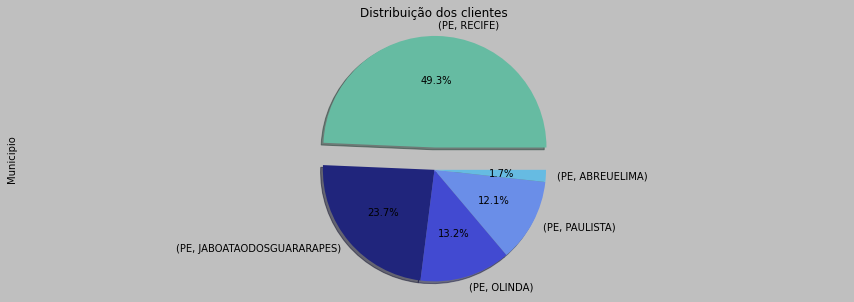

In [104]:
# Visualizando a distribuição pelas regiões
count = lista['Municipio'].groupby(lista.Estado).value_counts().sort_values(ascending=False).head(5)
count.plot(kind='pie', figsize=(14.8,5),colors=['#66bba2',"#20257C","#424ad1","#6a8ee8","#66bbe2"],explode=(0.2,0,0,0,0), shadow=True, autopct='%1.1f%%' )
plt.title("Distribuição dos clientes")
plt.axis("equal")
plt.show()

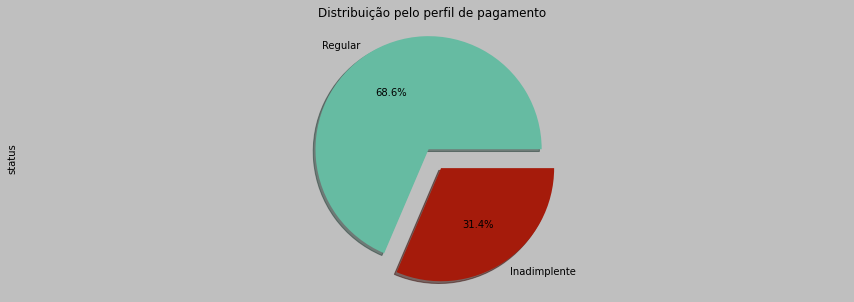

In [126]:
count = lista['status'].value_counts()
count.plot(kind='pie', figsize=(14.8,5),colors=['#66bba2',"#a51b0b"], explode=(0.2,0), shadow=True, autopct='%1.1f%%' )
plt.title("Distribuição pelo perfil de pagamento ")
plt.axis("equal")
plt.show()

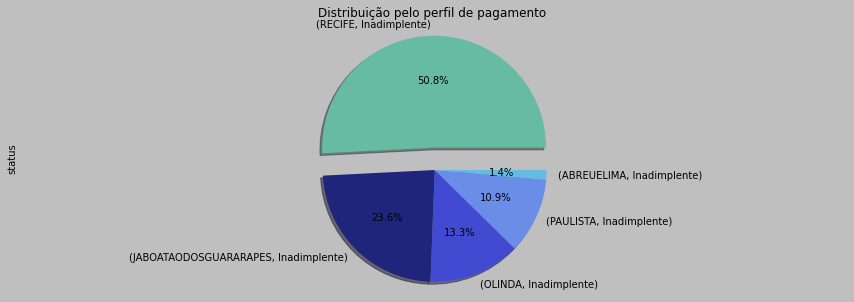

In [127]:
# visualizando a distribuição de perfil de pagamento
Inadimplente=lista['status']=="Inadimplente"
filtered_df = lista[Inadimplente]

count = filtered_df['status'].groupby(filtered_df.Municipio).value_counts().sort_values(ascending=False).head(5)
count.plot(kind='pie', figsize=(14.8,5),colors=['#66bba2',"#20257C","#424ad1","#6a8ee8","#66bbe2"],explode=(0.2,0,0,0,0), shadow=True, autopct='%1.1f%%' )
plt.title("Distribuição pelo perfil de pagamento ")
plt.axis("equal")
plt.show()

# Prevendo algumas situações

In [143]:
#Inicialmente irei transformar a coluna genero em categoria, para que fique como numero
#esses dados serão minhas features
labelencoder_X=LabelEncoder()
cols = ['status', 'Municipio']
X = lista.loc[:, cols].values
X[:,0] = labelencoder_X.fit_transform(X[:,0])
X[:,1] = labelencoder_X.fit_transform(X[:,1])

#Irei definir meu target
y = lista.status

In [144]:
#vamos realizar o particionamento direto com o scikit para treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('Existem {} amostras de treino e {} amostras de teste'.format(X_train.shape[0], X_test.shape[0]))

Existem 73962 amostras de treino e 31698 amostras de teste


In [145]:
#Vamos normalizar os dados
sc = StandardScaler()
sc.fit(X_train)
X_train_normalizado = sc.transform(X_train)
X_test_normalizado = sc.transform(X_test)
X_normalizado = np.vstack((X_train_normalizado, X_test_normalizado))
y_normalizado = np.hstack((y_train, y_test))

# Fontes


https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0
<br>https://pypi.org/project/pytesseract/
<br>https://medium.com/swlh/text-classification-using-the-bag-of-words-approach-with-nltk-and-scikit-learn-9a731e5c4e2f
<br>https://minerandodados.com.br/como-preparar-dados-de-texto-para-machine-learning/
<br>https://www.alura.com.br/artigos/como-remover-linhas-e-colunas-no-pandas